In [1]:
# --- 1. Gerekli Kütüphaneleri ve Ollama'yı Kur ---
%%capture
!pip install pypdf
!pip install tqdm
!pip install langchain langchain-community langchain-huggingface faiss-cpu sentence-transformers
!pip install -U langchain-ollama
!curl -fsSL https://ollama.com/install.sh | sh

In [2]:
import subprocess
import time
import os

process = subprocess.Popen(['ollama','serve'], stdout = subprocess.PIPE, stderr=subprocess.PIPE)
time.sleep(5)

!ollama pull llama3

## **Çıkmış Sorular Analizi**

  1. Soruların metinleri ve metadata (kavramlar) okunuyor.
  2. Önceden hazırlanmış **JSON haritaları** ve **ders özetleri (TXT)** ile karşılaştırılıyor.
  3. Kavram veya ana başlıklar soru metninde veya kavram listesinde geçiyorsa **puan** ekleniyor (skorlama).
  4. En yüksek puan alan ünite, o sorunun ünite tahmini olarak seçiliyor.

* **LLM yok**, tahminler tamamen:

  * Metin eşleşmeleri
  * Kavram eşleşmeleri
  * Basit skor sistemi

Bu kod, **kural ve istatistik tabanlı bir ünite tespit ajanı**dır, yapay zekâ veya doğal dil anlama modeli kullanmaz.




In [5]:
import json
import os
from collections import Counter

class SosyalPolitikaAnalizAjaniV2:
    def __init__(self, harita_klasoru, sorular_klasoru, ozet_klasoru):
        self.haritalar = self.yukle_json_klasoru(harita_klasoru)
        self.ozetler = self.yukle_txt_klasoru(ozet_klasoru)
        self.sorular_dosyalari = self.yukle_json_klasoru(sorular_klasoru)

    def yukle_json_klasoru(self, yol):
        veriler = {}
        if not os.path.exists(yol): return veriler
        for dosya in os.listdir(yol):
            if dosya.endswith(".json"):
                try:
                    with open(os.path.join(yol, dosya), "r", encoding="utf-8") as f:
                        veriler[dosya] = json.load(f)
                except: continue
        return veriler

    def yukle_txt_klasoru(self, yol):
        metinler = {}
        if not os.path.exists(yol): return metinler
        for dosya in os.listdir(yol):
            if dosya.endswith(".txt"):
                with open(os.path.join(yol, dosya), "r", encoding="utf-8") as f:
                    metinler[dosya] = f.read().lower()
        return metinler

    def temizle(self, metin):
        """Kelimeleri karşılaştırma için standart hale getirir."""
        return str(metin).lower().replace("İ", "i").replace("I", "ı").strip()

    def uniteyi_tespit_et(self, soru_obj):
        skorlar = Counter()
        soru_metni = self.temizle(soru_obj.get("SORU", ""))
        kavramlar = [self.temizle(k) for k in soru_obj["METADATA"].get("kavramlar", [])]

        # 1. JSON Haritaları Üzerinden Arama
        for dosya, data in self.haritalar.items():
            unite_id = data.get("unite_kuyne", dosya)
            terimler = [self.temizle(k["terim"]) for k in data.get("kritik_kavramlar", [])]
            basliklar = [self.temizle(b) for b in data.get("ana_basliklar", [])]

            # Kavram veya Soru içinde geçiyor mu?
            for t in terimler + basliklar:
                if t in soru_metni or any(t in kav for kav in kavramlar):
                    skorlar[unite_id] += 5 # Güçlü eşleşme

        # 2. TXT Özetleri Üzerinden Arama (Daha esnek)
        for dosya_adi, icerik in self.ozetler.items():
            for kav in kavramlar:
                if len(kav) > 3 and kav in icerik: # Kısa kelimeleri ele
                    skorlar[dosya_adi] += 2

        if skorlar:
            return skorlar.most_common(1)[0][0]
        return "Belirlenemedi"

    def analiz_et(self):
        rapor = Counter()
        for dosya, sorular in self.sorular_dosyalari.items():
            for soru in sorular:
                unite = self.uniteyi_tespit_et(soru)
                rapor[unite] += 1
        return rapor

# Çalıştır
ajan = SosyalPolitikaAnalizAjaniV2(
    harita_klasoru="/content/unite_haritalari",
    sorular_klasoru="/content/drive/MyDrive/islenmis_sorular-20251228T151025Z-3-001/islenmis_sorular",
    ozet_klasoru="/content/drive/MyDrive/sosyalpolitikaOzetTXT-20251228T151302Z-3-001/sosyalpolitikaOzetTXT"
)
sonuc = ajan.analiz_et()
print(sonuc)

Counter({'Belirlenemedi': 170, 'sosyalpolitikaozet16.txt': 50, 'sosyalpolitikaozet11.txt': 12, 'sosyalpolitikaozet12.txt': 10, 'sosyalpolitikaozet14.txt': 10, 'sosyalpolitikaozet9.txt': 7, 'sosyalpolitikaozet15.txt': 7, 'sosyalpolitikaozet10.txt': 3, 'sosyalpolitikaozet13.txt': 2})


170 sorunun hangi üniteden olduğu anlaşılamadı. Daha doğru sonuçlar için anlamsal arama kullanıldı

In [6]:
#Modelin daha hızlı çalışması için kitabın özeti kullanıldı.
import os
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# 1. Özetleri yükle
docs = []
ozet_yolu = "/content/drive/MyDrive/sosyalpolitikaOzetTXT-20251228T151302Z-3-001/sosyalpolitikaOzetTXT"

for dosya in os.listdir(ozet_yolu):
    if dosya.endswith(".txt"):
        with open(os.path.join(ozet_yolu, dosya), "r", encoding="utf-8") as f:
            text = f.read()
            docs.append(Document(page_content=text, metadata={"source": dosya}))

# 2. Parçalara böl
text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=80)
splits = text_splitter.split_documents(docs)

# 3. Model (Türkçe ve çok dilli desteği en iyi modellerden biri)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# 4. Vektör deposu
vectorstore = FAISS.from_documents(splits, embeddings)

print(f"{len(splits)} metin parçası anlamsal hafızaya alındı!")

/tmp/ipython-input-1866346952.py:23: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or da

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ 126 metin parçası anlamsal hafızaya alındı!


* **Amacı:** Her soruyu analiz edip öğrenciye “stratejik çalışma rehberi” üretmek; kritik kavramları, tuzak noktaları ve öğretim notlarını JSON formatında kaydetmek.

* **Nasıl çalışıyor:**

  1. Çıkmış sorular ve cevap anahtarları okunuyor.
  2. Her soru metni ve şıkları, JSON formatına dönüştürülüyor.
  3. **Ollama Llama 3 modeli** kullanılarak her soru için analiz alınıyor; LLM’den sadece JSON formatında çıktı isteniyor.
  4. Çıkan cevaplar temizlenip JSON’a çevriliyor ve ilgili soruya ekleniyor.
  5. Tüm soruların stratejik analizleri, dosya bazında kaydediliyor.

* **Özellikleri:**

  * Her soru için akademik seviye, kritik anahtar kelime, öğrenci tuzağı ve hoca notu belirleniyor.
  * İşlem otomatik, dosya bazlı ve tekrar kullanılabilir.
  * LLM ile yapılan analiz sayesinde sadece başlık değil, detaylı stratejik yönlendirme sağlanıyor.



In [ ]:
import re
import json
import os
from langchain_ollama import OllamaLLM

# --- 1. MODEL VE AYARLAR ---
# Ollama'nın bilgisayarınızda açık olduğundan emin olun!
llm = OllamaLLM(model="llama3")

input_klasoru = "/content/drive/MyDrive/cikmis_sorular"
cikti_klasoru = "/content/drive/MyDrive/islenmis_stratejik_sorular"
if not os.path.exists(cikti_klasoru): os.makedirs(cikti_klasoru)

HOCA_PROMPT = """
Sen, Sosyal Politika alanında uzman kıdemli bir profesörsün.
Verilen soruyu analiz ederek öğrenciye "stratejik istihbarat" üret.
SADECE JSON formatında yanıt ver. Başka açıklama yapma.

ÖRNEK ÇIKTI:
{
  "akademik_seviye": "Bilgi / Analiz",
  "soru_karakteri": "Kurum-Görev eşleştirmesi",
  "kritik_anahtar_kelime": "Soru kökündeki 'zorunlu sigorta' ifadesi",
  "ogrenci_tuzagi": "Bismarck ve Beveridge modelleri karıştırılabilir.",
  "hoca_notu": "Sigorta diyorsa Bismarck, evrensel hizmet diyorsa Beveridge'e git.",
  "kavramlar": ["Bismarck", "Sosyal Sigorta"]
}
"""

# --- 2. YARDIMCI FONKSİYONLAR ---
def json_temizle(raw_text):
    try:
        text = re.sub(r'```json|```', '', raw_text)
        match = re.search(r'(\{.*\})', text, re.DOTALL)
        if match:
            clean_json = match.group(1)
            clean_json = re.sub(r',\s*([\]}])', r'\1', clean_json)
            return clean_json
        return text
    except:
        return raw_text

def metni_jsona_cevir(ham_metin, cevap_anahtari_str, dosya_adi):
    cevaplar = cevap_anahtari_str.split()
    # Soruları rakamla başlayan (1. 2. gibi) bloklara ayırır
    soru_bloklari = re.split(r'\n(?=\d+\.)', ham_metin.strip())

    yerel_liste = []
    for i, blok in enumerate(soru_bloklari):
        match = re.match(r'(\d+)\.(.*)', blok.strip(), re.DOTALL)
        if match:
            icerik = match.group(2)
            parts = re.split(r'\s([A-E])\)\s', icerik)
            if len(parts) > 1:
                # Şıkları sözlük yapısına çevir
                siklar = {parts[j]: parts[j+1].split('\n')[0].strip() for j in range(1, len(parts), 2) if j+1 < len(parts)}
                yerel_liste.append({
                    "SORU_ID": f"{dosya_adi}_{i+1}",
                    "SORU": parts[0].strip().replace('\n', ' '),
                    "SIKLAR": siklar,
                    "CEVAP": cevaplar[i] if i < len(cevaplar) else "Bilinmiyor",
                    "STRATEJI": {}
                })
    return yerel_liste

# --- 3. ANA DÖNGÜ (İŞ AKIŞI) ---

is_listesi = {
    "guz_ara_sinav_2022_cikmis_sorular": "A A D C D E B D C B B E E E A A B C D C",
    "guz_ara_sinav_2023_cikmis_sorular": "C E A D C A B B C C E A E A B B D D D E",
    "guz_ara_sinav_2024_cikmis_sorular": "E D C C B A E C D B C A B D E B A D A E",
    "yaz_okulu_2023_cikmis_sorular": "A A D C E C D B D C B D A E A B E E B C",
    "yaz_okulu_2024_cikmis_sorular": "B D D A B B C C C B E E C A E D A A D E",
    "yaz_okulu_2025_cikmis_sorular": "E D D E A B E B E C C C A A D D A B C B"
}

for dosya_adi, cevaplar in is_listesi.items():
    dosya_yolu = os.path.join(input_klasoru, f"{dosya_adi}.txt")

    # Dosya var mı kontrolü
    if not os.path.exists(dosya_yolu):
        print(f"Dosya bulunamadı: {dosya_yolu}")
        continue

    with open(dosya_yolu, "r", encoding="utf-8") as f:
        ham_metin = f.read()

    # Soruları listeye dönüştür
    soru_listesi = metni_jsona_cevir(ham_metin, cevaplar, dosya_adi)

    # Her soru için LLM analizi al
    for soru in soru_listesi:
        prompt = f"{HOCA_PROMPT}\n\nSoru: {soru['SORU']}\nŞıklar: {soru['SIKLAR']}"
        try:
            raw_response = llm.invoke(prompt)
            res_text = raw_response.content if hasattr(raw_response, 'content') else raw_response

            clean_text = json_temizle(res_text)
            analiz = json.loads(clean_text)

            soru["STRATEJI"] = analiz
            print(f"{soru['SORU_ID']} analiz edildi.")
        except Exception as e:
            print(f"{soru['SORU_ID']} hatası: {e}")
            soru["STRATEJI"] = {"hata": "Analiz başarısız"}

    # Dosya bazlı kaydet
    cikti_yolu = os.path.join(cikti_klasoru, f"{dosya_adi}_stratejik.json")
    with open(cikti_yolu, "w", encoding="utf-8") as f:
        json.dump(soru_listesi, f, ensure_ascii=False, indent=2)

print("\nİşlem tamamlandı! Tüm dosyalar stratejik analizlerle güncellendi.")

* **Amacı:** Soruları önceden oluşturulmuş bir **vectorstore (vektör veritabanı)** kullanarak en yakın akademik üniteye eşleştirmek ve ünite dağılımını analiz etmek.

* **Nasıl çalışıyor:**

  1. JSON formatındaki tüm soru dosyalarını okur.
  2. Her soru için soru metni ve metadata’daki kavramları birleştirerek bir **anlamsal sorgu** oluşturur.
  3. Bu sorguyu **vectorstore.similarity_search** ile aratır; yani soru metni ile ünite özetleri veya kaynaklar arasındaki **embedding benzerliğine** bakar.
  4. En yüksek benzerliği olan üniteyi tahmin eder ve soru metadata’sına kaydeder.
  5. Tüm sorular üzerinden her üniteden kaç soru geldiğini sayar ve raporlar.


In [7]:
#Bu kod işlenmiş_stratejik_sorular verisi ile çalışıyor.
import json
import os
from collections import Counter
class HibritAnalizAjani:
    def __init__(self, vectorstore, sorular_klasoru):
        self.vectorstore = vectorstore
        self.sorular_dosyalari = self.yukle_json_klasoru(sorular_klasoru)

    def yukle_json_klasoru(self, yol):
        veriler = {}
        for dosya in os.listdir(yol):
            if dosya.endswith(".json"):
                with open(os.path.join(yol, dosya), "r", encoding="utf-8") as f:
                    veriler[dosya] = json.load(f)
        return veriler

    def analiz_et(self):
        rapor = Counter()
        for dosya, sorular in self.sorular_dosyalari.items():
            for soru in sorular:
                soru_metni = soru.get("SORU", "")
                kavramlar = " ".join(soru["METADATA"].get("kavramlar", []))
                sorgu = f"{soru_metni} {kavramlar}"

                # Anlamsal olarak en yakın üniteyi bul
                benzerler = self.vectorstore.similarity_search(sorgu, k=1)

                if benzerler:
                    tahmin_edilen_unite = benzerler[0].metadata["source"]
                    soru["METADATA"]["unite_no"] = tahmin_edilen_unite
                    rapor[tahmin_edilen_unite] += 1
                else:
                    rapor["Tamamen Belirlenemedi"] += 1
        return rapor

# Çalıştır ve sonucu gör
hibrit_ajan = HibritAnalizAjani(vectorstore, "/content/drive/MyDrive/islenmis_sorular-20251228T151025Z-3-001/islenmis_sorular")
yeni_sonuc = hibrit_ajan.analiz_et()

print("\n📊 HİBRİT ANALİZ SONUÇLARI (Anlamsal Eşleştirme Dahil):")
for unite, sayi in yeni_sonuc.items():
    print(f"📍 {unite}: {sayi} Soru")


📊 HİBRİT ANALİZ SONUÇLARI (Anlamsal Eşleştirme Dahil):
📍 sosyalpolitikaozet11.txt: 81 Soru
📍 sosyalpolitikaozet14.txt: 19 Soru
📍 sosyalpolitikaozet10.txt: 32 Soru
📍 sosyalpolitikaozet9.txt: 50 Soru
📍 sosyalpolitikaozet12.txt: 38 Soru
📍 sosyalpolitikaozet16.txt: 23 Soru
📍 sosyalpolitikaozet13.txt: 10 Soru
📍 sosyalpolitikaozet15.txt: 18 Soru


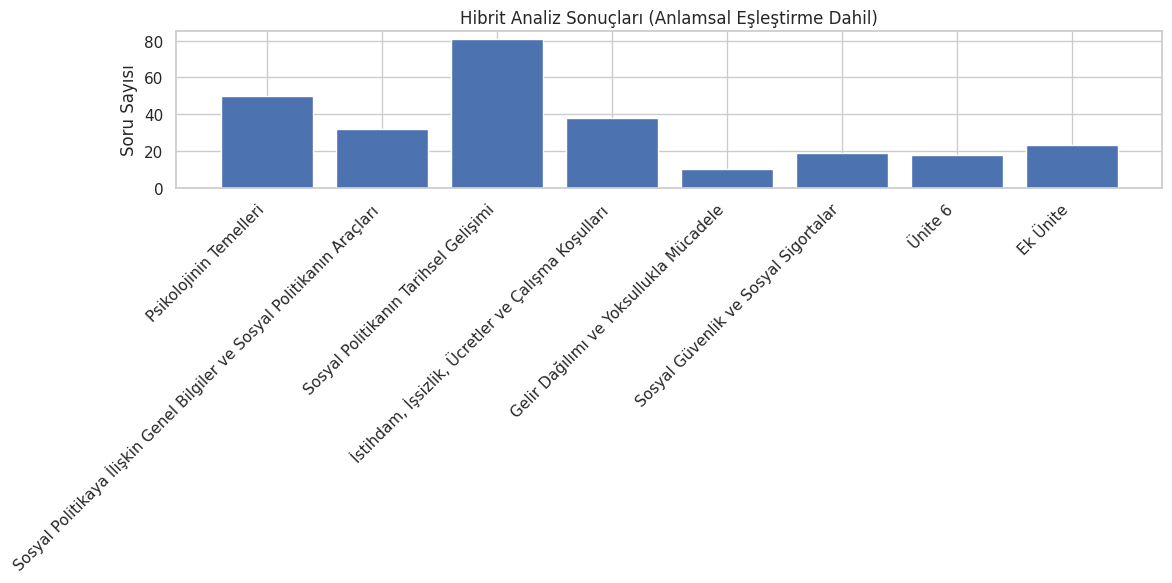

In [23]:
#görselleştirme
import matplotlib.pyplot as plt

veri = {
    "Psikolojinin Temelleri": 50,
    "Sosyal Politikaya İlişkin Genel Bilgiler ve Sosyal Politikanın Araçları": 32,
    "Sosyal Politikanın Tarihsel Gelişimi": 81,
    "İstihdam, İşsizlik, Ücretler ve Çalışma Koşulları": 38,
    "Gelir Dağılımı ve Yoksullukla Mücadele": 10,
    "Sosyal Güvenlik ve Sosyal Sigortalar": 19,
    "Ünite 6": 18,
    "Ek Ünite": 23
}

plt.figure(figsize=(12, 6))
plt.bar(veri.keys(), veri.values())
plt.xticks(rotation=45, ha="right")
plt.ylabel("Soru Sayısı")
plt.title("Hibrit Analiz Sonuçları (Anlamsal Eşleştirme Dahil)")
plt.tight_layout()
plt.show()


* **Raporlama:**

  * Ünitelere göre toplam soru sayısı ve sık sorulan konular listeleniyor.
  * Çıktı, öğrencinin hangi ünitelerde yoğunlaşması gerektiğini ve kritik konuları görmesini sağlıyor.
  * Bu sayede sınav odaklı, veri destekli bir strateji oluşturuluyor.


In [9]:
from collections import Counter, defaultdict

class DetayliAnalizAjani(HibritAnalizAjani):
    def analiz_et(self):
        # Ünite -> [Kavramlar listesi] şeklinde veri tutacağız
        unite_kavramlari = defaultdict(list)
        unite_soru_sayisi = Counter()

        print("🔍 Derinlemesine kavram analizi yapılıyor...")

        for dosya, sorular in self.sorular_dosyalari.items():
            for soru in sorular:
                soru_metni = soru.get("SORU", "")
                kavramlar = soru["METADATA"].get("kavramlar", [])
                sorgu = f"{soru_metni} {' '.join(kavramlar)}"

                # Anlamsal eşleştirme
                benzerler = self.vectorstore.similarity_search(sorgu, k=1)

                if benzerler:
                    unite = benzerler[0].metadata["source"]
                    unite_soru_sayisi[unite] += 1
                    # Bu ünitede hangi kavramlar geçmiş, listeye ekle
                    unite_kavramlari[unite].extend(kavramlar)

        # Raporlama Aşaması
        final_rapor = {}
        for unite in unite_soru_sayisi:
            # Her ünite için en popüler 5 kavramı bul
            populer_kavramlar = Counter(unite_kavramlari[unite]).most_common(5)
            final_rapor[unite] = {
                "soru_sayisi": unite_soru_sayisi[unite],
                "kritik_kavramlar": populer_kavramlar
            }

        return final_rapor

# Çalıştır ve Detaylı Raporu Gör
detayli_ajan = DetayliAnalizAjani(vectorstore, "/content/drive/MyDrive/islenmis_sorular-20251228T151025Z-3-001/islenmis_sorular")
detayli_sonuc = detayli_ajan.analiz_et()

print("\n" + "="*50)
print("🎓 SOSYAL POLİTİKA SINAV STRATEJİ RAPORU")
print("="*50)

for unite, veri in sorted(detayli_sonuc.items(), key=lambda x: x[1]['soru_sayisi'], reverse=True):
    print(f"\n📍 ÜNİTE: {unite}")
    print(f"📊 Toplam Soru: {veri['soru_sayisi']}")
    print(f"🔥 Sık Sorulan Kavramlar:")
    for kav, sayi in veri['kritik_kavramlar']:
        print(f"   - {kav} ({sayi} kez)")
    print("-" * 30)

🔍 Derinlemesine kavram analizi yapılıyor...

🎓 SOSYAL POLİTİKA SINAV STRATEJİ RAPORU

📍 ÜNİTE: sosyalpolitikaozet11.txt
📊 Toplam Soru: 81
🔥 Sık Sorulan Kavramlar:
   - Sosyal Politika (12 kez)
   - İstihdam (5 kez)
   - Risk (3 kez)
   - İş Sağlığı ve Güvenliği (3 kez)
   - Sosyal Güvenlik (3 kez)
------------------------------

📍 ÜNİTE: sosyalpolitikaozet9.txt
📊 Toplam Soru: 50
🔥 Sık Sorulan Kavramlar:
   - Sosyal Politika (18 kez)
   - Bakanlıklar (3 kez)
   - Sanayi Devrimi (3 kez)
   - Sosyal Dışlama (3 kez)
   - Kamu Yönetimi (2 kez)
------------------------------

📍 ÜNİTE: sosyalpolitikaozet12.txt
📊 Toplam Soru: 38
🔥 Sık Sorulan Kavramlar:
   - Sosyal Politika (3 kez)
   - Objektif yoksulluk (3 kez)
   - Sanayi Devrimi (2 kez)
   - Gelir Dağılımı (2 kez)
   - Fonksiyonel Gelir Dağılımı (2 kez)
------------------------------

📍 ÜNİTE: sosyalpolitikaozet10.txt
📊 Toplam Soru: 32
🔥 Sık Sorulan Kavramlar:
   - Sosyal Politika (4 kez)
   - Kolektivizm (3 kez)
   - Feodalizm (2 kez)
   

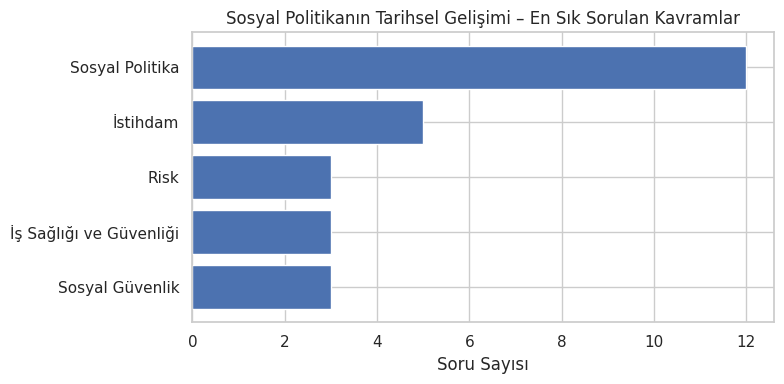

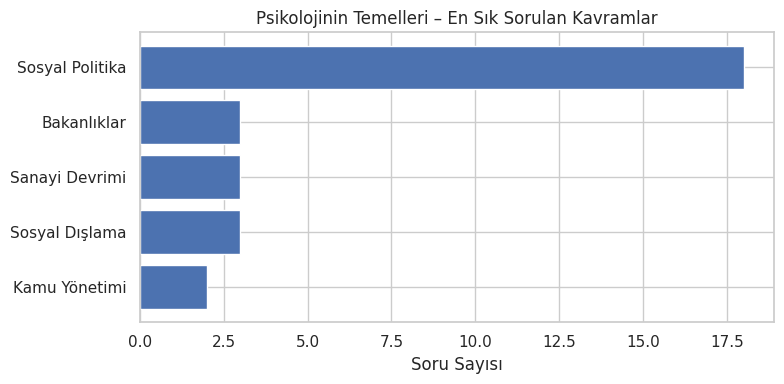

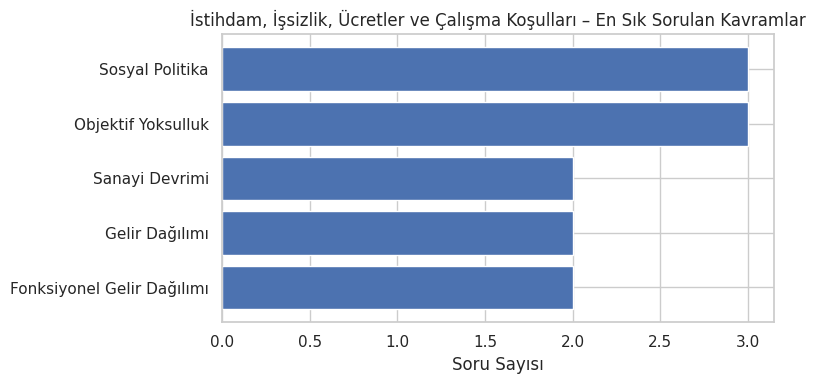

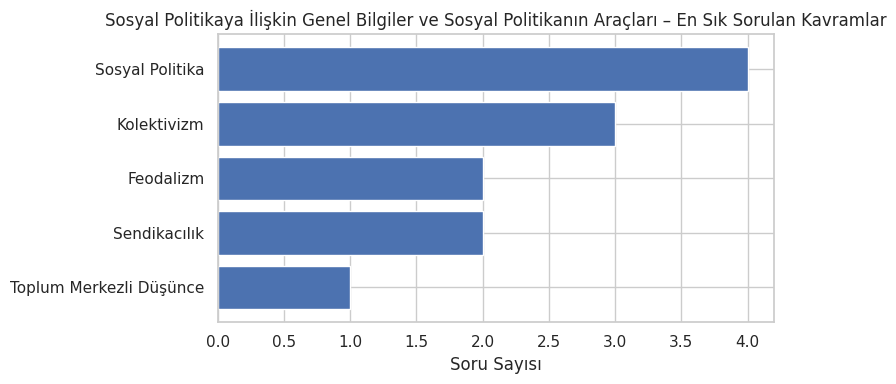

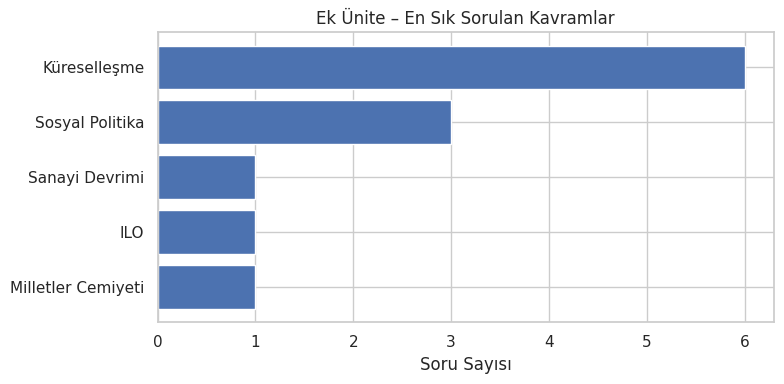

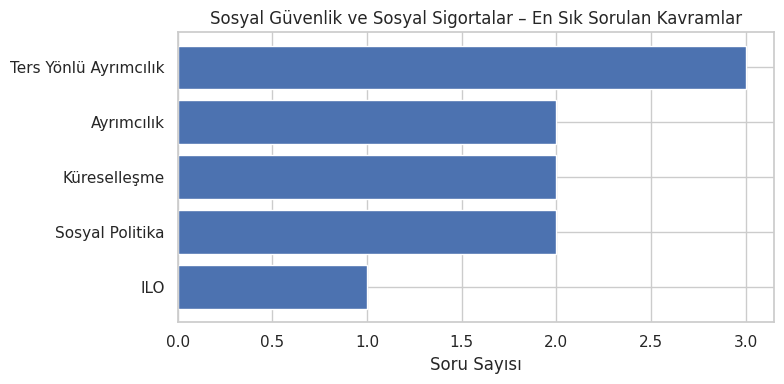

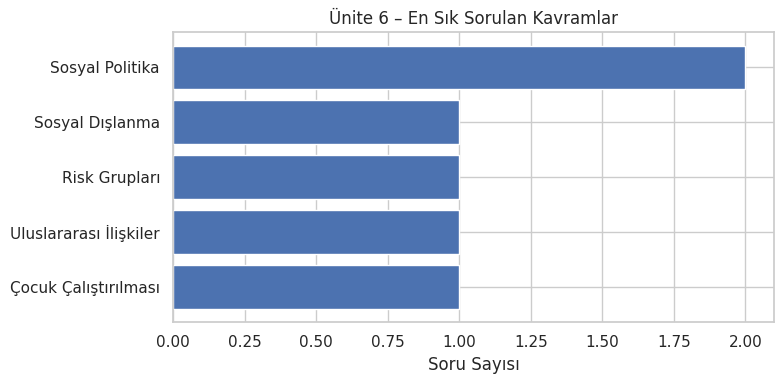

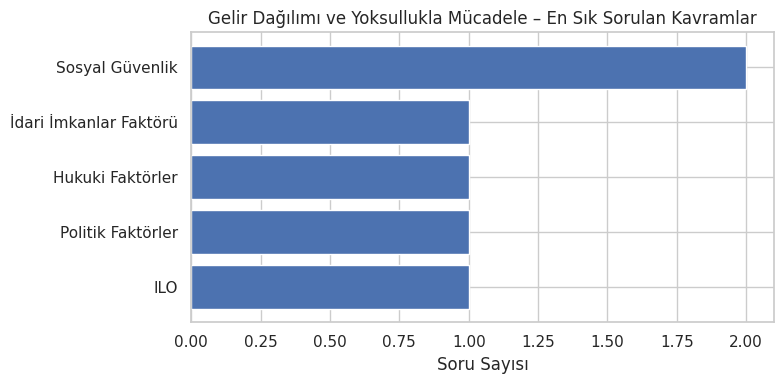

In [25]:
#görselleştirme
unite_basliklari = {
    "sosyalpolitikaozet9.txt": "Psikolojinin Temelleri",
    "sosyalpolitikaozet10.txt": "Sosyal Politikaya İlişkin Genel Bilgiler ve Sosyal Politikanın Araçları",
    "sosyalpolitikaozet11.txt": "Sosyal Politikanın Tarihsel Gelişimi",
    "sosyalpolitikaozet12.txt": "İstihdam, İşsizlik, Ücretler ve Çalışma Koşulları",
    "sosyalpolitikaozet13.txt": "Gelir Dağılımı ve Yoksullukla Mücadele",
    "sosyalpolitikaozet14.txt": "Sosyal Güvenlik ve Sosyal Sigortalar",
    "sosyalpolitikaozet15.txt": "Ünite 6",
    "sosyalpolitikaozet16.txt": "Ek Ünite"
}

veri = {
    "sosyalpolitikaozet11.txt": {
        "Sosyal Politika": 12,
        "İstihdam": 5,
        "Risk": 3,
        "İş Sağlığı ve Güvenliği": 3,
        "Sosyal Güvenlik": 3
    },
    "sosyalpolitikaozet9.txt": {
        "Sosyal Politika": 18,
        "Bakanlıklar": 3,
        "Sanayi Devrimi": 3,
        "Sosyal Dışlama": 3,
        "Kamu Yönetimi": 2
    },
    "sosyalpolitikaozet12.txt": {
        "Sosyal Politika": 3,
        "Objektif Yoksulluk": 3,
        "Sanayi Devrimi": 2,
        "Gelir Dağılımı": 2,
        "Fonksiyonel Gelir Dağılımı": 2
    },
    "sosyalpolitikaozet10.txt": {
        "Sosyal Politika": 4,
        "Kolektivizm": 3,
        "Feodalizm": 2,
        "Sendikacılık": 2,
        "Toplum Merkezli Düşünce": 1
    },
    "sosyalpolitikaozet16.txt": {
        "Küreselleşme": 6,
        "Sosyal Politika": 3,
        "Sanayi Devrimi": 1,
        "ILO": 1,
        "Milletler Cemiyeti": 1
    },
    "sosyalpolitikaozet14.txt": {
        "Ters Yönlü Ayrımcılık": 3,
        "Ayrımcılık": 2,
        "Küreselleşme": 2,
        "Sosyal Politika": 2,
        "ILO": 1
    },
    "sosyalpolitikaozet15.txt": {
        "Sosyal Politika": 2,
        "Sosyal Dışlanma": 1,
        "Risk Grupları": 1,
        "Uluslararası İlişkiler": 1,
        "Çocuk Çalıştırılması": 1
    },
    "sosyalpolitikaozet13.txt": {
        "Sosyal Güvenlik": 2,
        "İdari İmkanlar Faktörü": 1,
        "Hukuki Faktörler": 1,
        "Politik Faktörler": 1,
        "ILO": 1
    }
}

import matplotlib.pyplot as plt

for unite, kavramlar in veri.items():
    baslik = unite_basliklari.get(unite, unite)

    kavram_isimleri = list(kavramlar.keys())
    sayilar = list(kavramlar.values())

    plt.figure(figsize=(8, 4))
    plt.barh(kavram_isimleri, sayilar)
    plt.xlabel("Soru Sayısı")
    plt.title(f"{baslik} – En Sık Sorulan Kavramlar")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()



In [27]:
KLASOR_YOLU = "/content/drive/MyDrive/islenmis_stratejik_sorular"
import pandas as pd
import json
def json_dosyadan_tablo_uret(dosya_yolu):
    with open(dosya_yolu, "r", encoding="utf-8") as f:
        sorular = json.load(f)

    satirlar = []

    for s in sorular:
        strateji = s.get("STRATEJI", {})

        satirlar.append({
            "SORU_ID": s.get("SORU_ID"),
            "SORU": s.get("SORU"),
            "DOĞRU CEVAP": s.get("CEVAP"),
            "AKADEMİK SEVİYE": strateji.get("akademik_seviye", "-"),
            "SORU TÜRÜ": strateji.get("soru_karakteri", "-"),
            "KRİTİK ANAHTAR": strateji.get("kritik_anahtar_kelime", "-"),
            "KAVRAMLAR": ", ".join(strateji.get("kavramlar", []))
        })

    return pd.DataFrame(satirlar)


İşlenmiş çıkmış soruların tablosu

In [60]:
import pandas as pd
import json
import os

def tablo_olustur(json_dosya_yolu, cikti_adi="Guz_Ara_Sinav_2024_Analiz_Raporu.csv"):
    with open(json_dosya_yolu, "r", encoding="utf-8") as f:
        sorular = json.load(f)

    rapor_verisi = []

    for s in sorular:
        strateji = s.get("STRATEJI", {})

        rapor_verisi.append({
            "Soru ID": s.get("SORU_ID"),
            "Soru Metni": s.get("SORU")[:150] + "..." if len(s.get("SORU", "")) > 150 else s.get("SORU"),
            "Doğru Şık": s.get("CEVAP"),
            "Akademik Seviye": strateji.get("akademik_seviye", "Bilgi"),
            "Soru Karakteri": strateji.get("soru_karakteri", "-"),
            "Kritik İpucu": strateji.get("kritik_anahtar_kelime", "-"),
            "Öğrenci Tuzağı": strateji.get("ogrenci_tuzagi", "-"),
            "Hoca Notu / Strateji": strateji.get("hoca_notu", "-"),
            "Temel Kavramlar": ", ".join(strateji.get("kavramlar", []))
        })

    # DataFrame Oluştur
    df = pd.DataFrame(rapor_verisi)

    # Excel uyumlu CSV kaydı (Türkçe karakter desteği için utf-8-sig)
    df.to_csv(cikti_adi, index=False, encoding="utf-8-sig")

    print(f"-Rapor Hazır: {cikti_adi}")
    return df

# --- ÇALIŞTIR ---
dosya = "/content/drive/MyDrive/islenmis_stratejik_sorular/guz_ara_sinav_2024_cikmis_sorular_stratejik.json"
if os.path.exists(dosya):
    rapor_df = tablo_olustur(dosya)

    display(rapor_df.head())
else:
    print(" Dosya yolu hatalı, lütfen yolu kontrol edin.")

✅ Rapor Hazır: Guz_Ara_Sinav_2024_Analiz_Raporu.csv


,Soru ID,Soru Metni,Doğru Şık,Akademik Seviye,Soru Karakteri,Kritik İpucu,Öğrenci Tuzağı,Hoca Notu / Strateji,Temel Kavramlar
0,guz_ara_sinav_2024_cikmis_sorular_2,Aşağıdakilerden hangisi Sanayi Devriminin orta...,D,Bilgi / Analiz,Kurum-Görev eşleştirmesi,Sanayi Devrimi,"İki seçenek, Sanayi Devriminin ortaya çıkardığ...",A ve B seçenekler işçi sınıfının ortaya çıkışı...,"Sanayi Devrimi, İşçi Sınıfı, Liberalizm"
1,guz_ara_sinav_2024_cikmis_sorular_3,Çalışma hayatına ilişkin sorunlara çözüm bulun...,C,Bilgi / Analiz,Tarihsel Belgeler Eşleştirmesi,1944 yılına işaret eden 'belge',"Sosyal Diyalog, Üçlü Katılım Yolu","Belge, ücretlilerin durumunu etkileyen ekonomi...","Beveridge Raporu, Atlantik Şartı, İnsan Haklar..."
2,guz_ara_sinav_2024_cikmis_sorular_4,Üretim faktörü olarak insanı ele alarak işgücü...,C,Bilgi / Analiz,Kurum-Görev eşleştirmesi,Üretim faktörü olarak insanı ele alarak,"Çalışma ekonomisi, ücret konularına odaklandığ...","Insanları merkez alan ekonomi dalı, ücret konu...","Çalışma ekonomisi, Ücret"
3,guz_ara_sinav_2024_cikmis_sorular_5,İktisadi faaliyetin emek unsurunun tutsaklar v...,B,Bilgi / Analiz,Tarih-Görev eşleştirmesi,Köleler,Kompleks bir durum: Bismarck modelleri zorunlu...,Sigortalama diyorsa klasik kapitalist toplum d...,"Bismarck, Sosyal Sigorta, Köleler, Feodalizm"
4,guz_ara_sinav_2024_cikmis_sorular_6,"Mülkiyet ve egemenliğin birbirine katıldığı, s...",A,Bilgi,-,-,-,-,


In [61]:
# Sınavın genel zorluk ve karakter dağılımını hesapla
print("--- 2024 GÜZ ARA SINAV ÖZET İSTATİSTİKLERİ ---")
print(f"Toplam Soru: {len(rapor_df)}")
print("\nSoru Türü Dağılımı:")
print(rapor_df["Soru Karakteri"].value_counts())
print("\nAkademik Seviye Dağılımı:")
print(rapor_df["Akademik Seviye"].value_counts())

--- 2024 GÜZ ARA SINAV ÖZET İSTATİSTİKLERİ ---
Toplam Soru: 20

Soru Türü Dağılımı:
Soru Karakteri
Kurum-Görev eşleştirmesi          14
-                                  3
Tarihsel Belgeler Eşleştirmesi     1
Tarih-Görev eşleştirmesi           1
Faktör eşleştirmesi                1
Name: count, dtype: int64

Akademik Seviye Dağılımı:
Akademik Seviye
Bilgi / Analiz    17
Bilgi              3
Name: count, dtype: int64


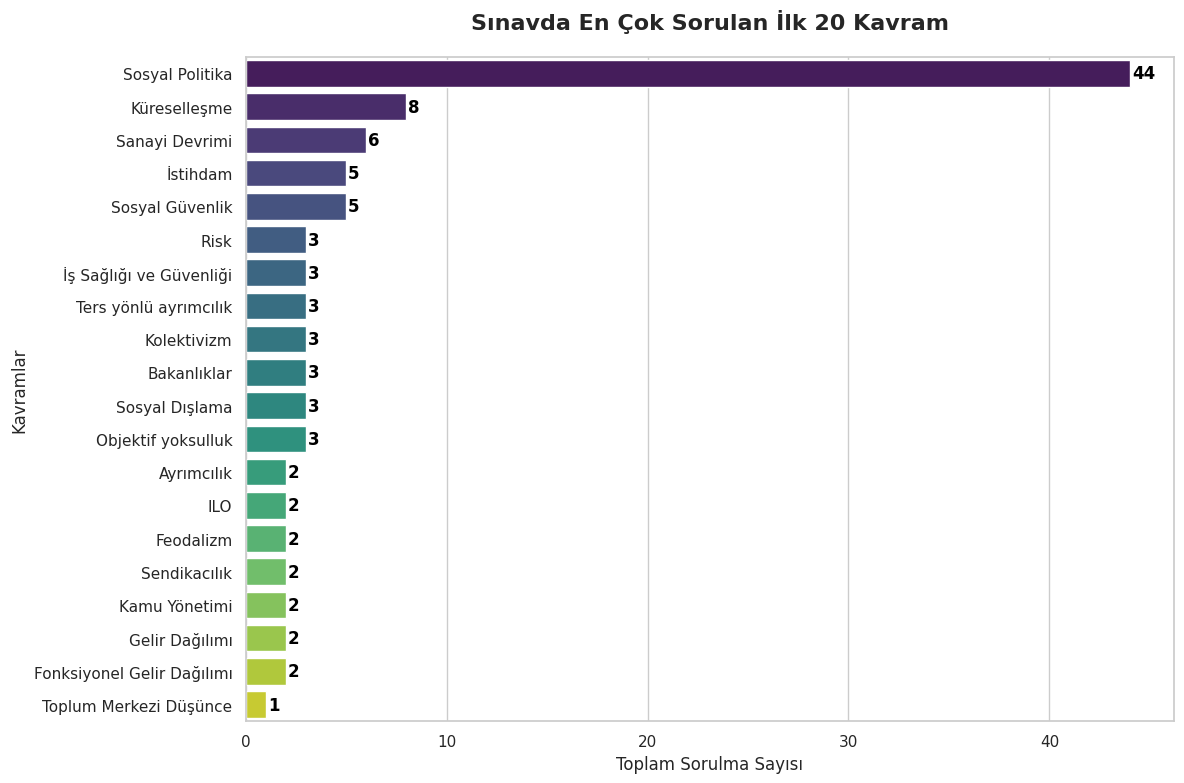

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def kavram_frekans_grafigi_ciz(analiz_sonucu, top_n=15):
    """
    Tüm ünitelerdeki kavramları birleştirir ve en çok sorulanları grafik olarak çizer.
    """
    tum_kavramlar = []

    # 1. Tüm ünitelerdeki kavramları tek bir listede topla
    for unite_adi, veri in analiz_sonucu.items():
        # Her kavramın frekansı kadar listeye ekle (sayi kadar tekrar et)
        for kav, sayi in veri['kritik_kavramlar']:
            tum_kavramlar.extend([kav] * sayi)

    # 2. Genel toplam frekansları hesapla
    kavram_sayici = Counter(tum_kavramlar).most_common(top_n)

    # Veriyi grafik için hazırla
    kavramlar = [k[0] for k in kavram_sayici]
    frekanslar = [k[1] for k in kavram_sayici]

    # 3. Grafik Çizimi
    plt.figure(figsize=(12, 8))
    sns.set_theme(style="whitegrid")

    # Renkli sütun grafiği oluştur
    ax = sns.barplot(x=frekanslar, y=kavramlar, hue=kavramlar, palette="viridis", legend=False)

    # Grafik başlıkları ve etiketler
    plt.title(f"Sınavda En Çok Sorulan İlk {top_n} Kavram", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Toplam Sorulma Sayısı", fontsize=12)
    plt.ylabel("Kavramlar", fontsize=12)

    # Değerleri sütunların üzerine yaz
    for i, v in enumerate(frekanslar):
        ax.text(v + 0.1, i, str(v), color='black', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- Çalıştırma ---
# Mevcut analiz sonucunu fonksiyona gönderiyoruz
kavram_frekans_grafigi_ciz(detayli_sonuc, top_n=20)

Tuzaklı konular

In [14]:
import os
import json

KLASOR_YOLU = "/content/drive/MyDrive/islenmis_stratejik_sorular"

tuzakli_konular = []

# Klasördeki tüm dosyaları tara
for dosya in os.listdir(KLASOR_YOLU):
    if dosya.endswith(".json"):
        dosya_yolu = os.path.join(KLASOR_YOLU, dosya)

        with open(dosya_yolu, "r", encoding="utf-8") as f:
            try:
                veri_listesi = json.load(f)
            except json.JSONDecodeError:
                print(f"JSON okunamadı: {dosya}")
                continue

        # Dosya içindeki sorular
        for soru in veri_listesi:
            strateji = soru.get("STRATEJI")

            if strateji and "ogrenci_tuzagi" in strateji:
                for kavram in strateji.get("kavramlar", []):
                    tuzakli_konular.append({
                        "dosya": dosya,
                        "kavram": kavram,
                        "tuzak": strateji.get("ogrenci_tuzagi"),
                        "hoca_notu": strateji.get("hoca_notu")
                    })

print(f"Toplam {len(tuzakli_konular)} adet tuzaklı konu bulundu.")


🎯 Toplam 301 adet tuzaklı konu bulundu.


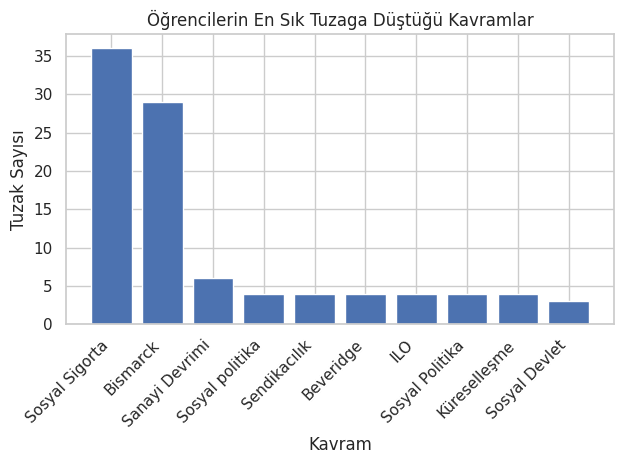

In [30]:
import os
import json
import matplotlib.pyplot as plt
from collections import Counter

KLASOR_YOLU = "/content/drive/MyDrive/islenmis_stratejik_sorular"

tuzakli_kavramlar = []

for dosya in os.listdir(KLASOR_YOLU):
    if dosya.endswith(".json"):
        with open(os.path.join(KLASOR_YOLU, dosya), "r", encoding="utf-8") as f:
            veri = json.load(f)

        for soru in veri:
            strateji = soru.get("STRATEJI", {})
            if "ogrenci_tuzagi" in strateji:
                for kavram in strateji.get("kavramlar", []):
                    tuzakli_kavramlar.append(kavram)

# Frekans hesabı
kavram_sayaci = Counter(tuzakli_kavramlar)
en_sik_10 = kavram_sayaci.most_common(10)

kavramlar = [k for k, _ in en_sik_10]
sayilar = [v for _, v in en_sik_10]

plt.figure()
plt.bar(kavramlar, sayilar)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Kavram")
plt.ylabel("Tuzak Sayısı")
plt.title("Öğrencilerin En Sık Tuzaga Düştüğü Kavramlar")
plt.tight_layout()
plt.show()


In [ ]:
import json
import os

KAYIT_YOLU = "/content/drive/MyDrive/llm_besleme"
os.makedirs(KAYIT_YOLU, exist_ok=True)

cikis_dosyasi = os.path.join(KAYIT_YOLU, "sinav_tuzaklari_ozet.json")

with open(cikis_dosyasi, "w", encoding="utf-8") as f:
    json.dump(tuzakli_konular, f, ensure_ascii=False, indent=2)

print(f"LLM besleme dosyası kaydedildi: {cikis_dosyasi}")


## SORU - CEVAP CHATBOT (AÖF KİTAPLARI İLE RAG)

In [65]:
import os
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

# 1. Embedding Modeli
from langchain_community.embeddings import HuggingFaceEmbeddings

#Başta OllamaEmbedding kullanıldı ancak daha sonra zaman avantajından dolayı huggingface seçildi
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

def tum_kitaplari_yukle_ve_vektorize_et(klasor_yolu, vektor_db_yolu="faiss_index"):
    all_documents = []

    # Klasördeki tüm dosyaları tara
    print(f"📂 {klasor_yolu} klasörü taranıyor...")
    for dosya in os.listdir(klasor_yolu):
        if dosya.endswith(".pdf"):
            tam_yol = os.path.join(klasor_yolu, dosya)
            print(f"📖 {dosya} okunuyor...")

            # PDF Loader kullanıyoruz
            loader = PyPDFLoader(tam_yol)
            # Sayfa sayfa yükle ve metadata ekle (Hangi ünite olduğu kaybolmasın)
            sayfalar = loader.load()
            all_documents.extend(sayfalar)

    # 2. Metni Parçala
    # chunk_size'ı 1000 yaparak anlam bütünlüğünü koruyoruz
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    parcalar = text_splitter.split_documents(all_documents)
    print(f" Toplam {len(parcalar)} metin parçasına bölündü.")

    # 3. Vektör Veritabanını Oluştur veya Güncelle
    if not os.path.exists(vektor_db_yolu):
        print(" Yeni vektör hafızası oluşturuluyor (Bu biraz vakit alabilir)...")
        vectorstore = FAISS.from_documents(parcalar, embeddings)
    else:
        print(" Mevcut hafıza yükleniyor ve üzerine ekleniyor...")
        vectorstore = FAISS.load_local(vektor_db_yolu, embeddings, allow_dangerous_deserialization=True)
        vectorstore.add_documents(parcalar)

    vectorstore.save_local(vektor_db_yolu)
    print(f"Hafıza '{vektor_db_yolu}' klasörüne kaydedildi.")
    return vectorstore

# --- ÇALIŞTIR ---
klasor = "/content/drive/MyDrive/sosyalpolitikatamkitap-20251228T151353Z-3-001/sosyalpolitikatamkitap"
vektor_merkezi = tum_kitaplari_yukle_ve_vektorize_et(klasor)

📂 /content/drive/MyDrive/sosyalpolitikatamkitap-20251228T151353Z-3-001/sosyalpolitikatamkitap klasörü taranıyor...
📖 Unite1.pdf okunuyor...
📖 Unite2.pdf okunuyor...
📖 Unite3.pdf okunuyor...
📖 Unite4.pdf okunuyor...
📖 Unite5.pdf okunuyor...
📖 Unite6.pdf okunuyor...
📖 Unite7.pdf okunuyor...
📖 Unite8.pdf okunuyor...
✂️ Toplam 1127 metin parçasına bölündü.
🧠 Yeni vektör hafızası oluşturuluyor (Bu biraz vakit alabilir)...
✅ İşlem tamam! Hafıza 'faiss_index' klasörüne kaydedildi.


In [68]:
from langchain_ollama import OllamaLLM
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

class PhilosophyStudyAgent:
    def __init__(self, faiss_path):
        # LLM (Anlatım için)
        self.llm = OllamaLLM(model="llama3")



        # Embedding (FAISS ile AYNI OLMALI)
        self.embeddings = HuggingFaceEmbeddings(
            model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
        )

        # Vector DB yükle
        self.vectorstore = FAISS.load_local(
            faiss_path,
            self.embeddings,
            allow_dangerous_deserialization=True
        )

    def cevapla(self, kullanici_sorusu):
        """TEK GİRİŞ NOKTASI"""
        dokumanlar = self.vectorstore.similarity_search(
            kullanici_sorusu, k=3
        )

        baglam = "\n\n".join([d.page_content for d in dokumanlar])

        prompt = f"""
        Sen Anadolu Üniversitesi Açıköğretim Felsefe bölümü için
        çıkmış sorulara dayalı çalışan bir akademik asistansın.

        Amaç:
        - Öğrenciye sınavda hızlı ve doğru cevap verebilecek bilgi sağlamak
        - Gereksiz uzun açıklamalardan kaçınmak
        - Anahtar kavramları ve ayırt edici farkları belirtmek

        Kurallar:
        1. Cevap kısa, net ve doğrudan olmalı.
        2. Gerekirse madde madde açıklama yap.
        3. Tanımlar + ayırt edici farklar varsa belirt.
        4. Örnek verirken kısa ve anlaşılır olmalı.
        5. Cevap sadece Türkçe olmalı.

        BAĞLAM (geçmiş çıkmış sorular ve özetler):
        {baglam}

        SORU:
        {kullanici_sorusu}

        Lütfen cevabı sınav odaklı ve anlaşılır şekilde ver.
        """

        return self.llm.invoke(prompt)


In [69]:
agent = PhilosophyStudyAgent(
    faiss_path="/content/faiss_index"
)


In [70]:
cevap = agent.cevapla(
    "Platon'un idealar kuramı nedir?"
)

print(cevap)


Platon'un idealar kuramı, gerçekliğin farklı seviyelerinde var olan ideal forms (ideal formlar) aracılığıyla anlaşılabileceği teorisidir. Bu teoride, Platon, dünya üzerinde görülen nesnelerin, yalnızca bir takım ideal formları tarafından temsil edilen real (gerçek) formlardan kopuk ve bozulmuş hâllerini savunur. Ideal formlar, mutlak gerçeklik ve kaliteyi temsil ederken, Dünya'daki objeler, bu ideal formlara göre deformasyon ya da bozulma geçirmiştir.

Platon'un idealar kuramı, metafiziksel bir teori olup, var olan şeylerin doğası ve niteliği üzerine kuruludur. Bu teoride, Platon, idea (ideal) ve aletheia (gerçeklik) arasındaki bağlantıyı vurgular.


## ÖĞRENCİ YÖNLENDİRME KOÇU

* **Amacı:** Çıkmış sorular ve kritik “tuzak” kavramları üzerinden, hangi kavramların daha önemli olduğunu belirleyip öğrencinin sınav odaklı çalışmasını optimize etmek.

* **Nasıl çalışıyor:**

  1. `DataLoaderAgent` sınıfı, stratejik analiz edilmiş soruları ve tuzak kavram listesini yükler.
  2. `ConceptAnalyzerAgent` sınıfı, sorularda geçen kavramların **frekansını ve hangi ünitelerde geçtiğini** analiz eder.
  3. `PriorityAgent` sınıfı, kavramlara bir **öncelik skoru** atar; skor frekans, ünite sayısı ve tuzak kavram olup olmamasına göre hesaplanır. Her kavram için çalışma gerekçesini açıklar.
  4. `StudyPlannerAgent` sınıfı, en yüksek skora sahip kavramlardan bir **çalışma planı** oluşturur; kavram, risk durumu (tuzaklı veya normal), ilgili üniteler ve çalışma gerekçesi listelenir.

* **Çıktı:**

  * Öğrenci, hangi kavramlara öncelik vermesi gerektiğini, hangi ünitelerde yoğunlaştığını ve tuzaklı noktaları görebilir.
  * Bu sayede veri destekli, stratejik ve kişiselleştirilmiş bir çalışma rehberi sunulur.


In [31]:
from dataclasses import dataclass
from collections import Counter, defaultdict
import json, os

@dataclass
class ConceptProfile:
    name: str
    frequency: int
    units: list
    trap: bool
    score: float
    explanation: str

class DataLoaderAgent:
    def __init__(self, stratejik_path, tuzak_path):
        self.stratejik_path = stratejik_path
        self.tuzak_path = tuzak_path

    def load_strategic_questions(self):
        data = []
        for file in os.listdir(self.stratejik_path):
            if file.endswith(".json"):
                with open(os.path.join(self.stratejik_path, file), encoding="utf-8") as f:
                    data.append((file.replace(".json",""), json.load(f)))
        return data

    def load_trap_concepts(self):
        with open(self.tuzak_path, encoding="utf-8") as f:
            return set(item["kavram"] for item in json.load(f))

class ConceptAnalyzerAgent:
    def analyze(self, strategic_data):
        freq = Counter()
        unit_map = defaultdict(set)

        for unit, questions in strategic_data:
            for q in questions:
                for k in q.get("STRATEJI", {}).get("kavramlar", []):
                    freq[k] += 1
                    unit_map[k].add(unit)

        return freq, unit_map

class PriorityAgent:
    def score(self, freq, unit_map, trap_set):
        profiles = []

        for kavram, f in freq.items():
            unit_count = len(unit_map[kavram])
            is_trap = kavram in trap_set

            # Skor formülü (bilimsel mantık)
            score = (
                f * 1.5 +
                unit_count * 1.2 +
                (3 if is_trap else 0)
            )

            explanation = self._explain(kavram, f, unit_count, is_trap)

            profiles.append(
                ConceptProfile(
                    name=kavram,
                    frequency=f,
                    units=list(unit_map[kavram]),
                    trap=is_trap,
                    score=round(score, 2),
                    explanation=explanation
                )
            )

        return sorted(profiles, key=lambda x: x.score, reverse=True)

    def _explain(self, kavram, freq, unit_count, trap):
        reasons = []
        reasons.append(f"{freq} soruda sorulmuş")
        reasons.append(f"{unit_count} farklı ünitede geçiyor")
        if trap:
            reasons.append("öğrenciler sıklıkla hata yapıyor")
        return " • ".join(reasons)

class StudyPlannerAgent:
    def generate(self, concept_profiles, top_n=10):
        plan = []

        for c in concept_profiles[:top_n]:
            plan.append({
                "Kavram": c.name,
                "Skor": c.score,
                "Risk": "🚨 Tuzaklı" if c.trap else "Normal",
                "Üniteler": ", ".join(c.units),
                "Neden Çalışmalısın": c.explanation
            })

        return plan

def run_student_guidance_agent():
    BASE = "/content/drive/MyDrive"

    loader = DataLoaderAgent(
        f"{BASE}/islenmis_stratejik_sorular",
        f"{BASE}/llm_besleme/sinav_tuzaklari_ozet.json"
    )

    analyzer = ConceptAnalyzerAgent()
    priority = PriorityAgent()
    planner = StudyPlannerAgent()

    strategic_data = loader.load_strategic_questions()
    trap_set = loader.load_trap_concepts()

    freq, unit_map = analyzer.analyze(strategic_data)
    profiles = priority.score(freq, unit_map, trap_set)
    plan = planner.generate(profiles)

    print("\n🎓 SOSYAL POLİTİKA – KİŞİSEL ÇALIŞMA STRATEJİSİ\n")

    for i, p in enumerate(plan, 1):
        print(f"{i}. {p['Kavram']} ({p['Risk']})")
        print(f"   Skor: {p['Skor']}")
        print(f"   Üniteler: {p['Üniteler']}")
        print(f"   Gerekçe: {p['Neden Çalışmalısın']}")
        print("-" * 60)

run_student_guidance_agent()



🎓 SOSYAL POLİTİKA – KİŞİSEL ÇALIŞMA STRATEJİSİ

1. Sosyal Sigorta (🚨 Tuzaklı)
   Skor: 65.4
   Üniteler: yaz_okulu_2024_cikmis_sorular_stratejik, guz_ara_sinav_2022_cikmis_sorular_stratejik, guz_ara_sinav_2024_cikmis_sorular_stratejik, yaz_okulu_2025_cikmis_sorular_stratejik, yaz_okulu_2023_cikmis_sorular_stratejik, guz_ara_sinav_2022_cikmis_sorular_ustapiyade, guz_ara_sinav_2023_cikmis_sorular_stratejik
   Gerekçe: 36 soruda sorulmuş • 7 farklı ünitede geçiyor • öğrenciler sıklıkla hata yapıyor
------------------------------------------------------------
2. Bismarck (🚨 Tuzaklı)
   Skor: 54.9
   Üniteler: yaz_okulu_2024_cikmis_sorular_stratejik, guz_ara_sinav_2022_cikmis_sorular_stratejik, guz_ara_sinav_2024_cikmis_sorular_stratejik, yaz_okulu_2025_cikmis_sorular_stratejik, yaz_okulu_2023_cikmis_sorular_stratejik, guz_ara_sinav_2022_cikmis_sorular_ustapiyade, guz_ara_sinav_2023_cikmis_sorular_stratejik
   Gerekçe: 29 soruda sorulmuş • 7 farklı ünitede geçiyor • öğrenciler sıklıkla hat

📊 Sosyal Politika - Kişisel Çalışma Stratejisi Tablosu:

         Kavram  Skor  Üniteler  Soru Sayısı  Tuzak
 Sosyal Sigorta  65.4         7           36   True
       Bismarck  54.9         7           29   True
 Sanayi Devrimi  18.0         5            6   True
Sosyal politika  12.6         3            4   True


/tmp/ipython-input-1954021136.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


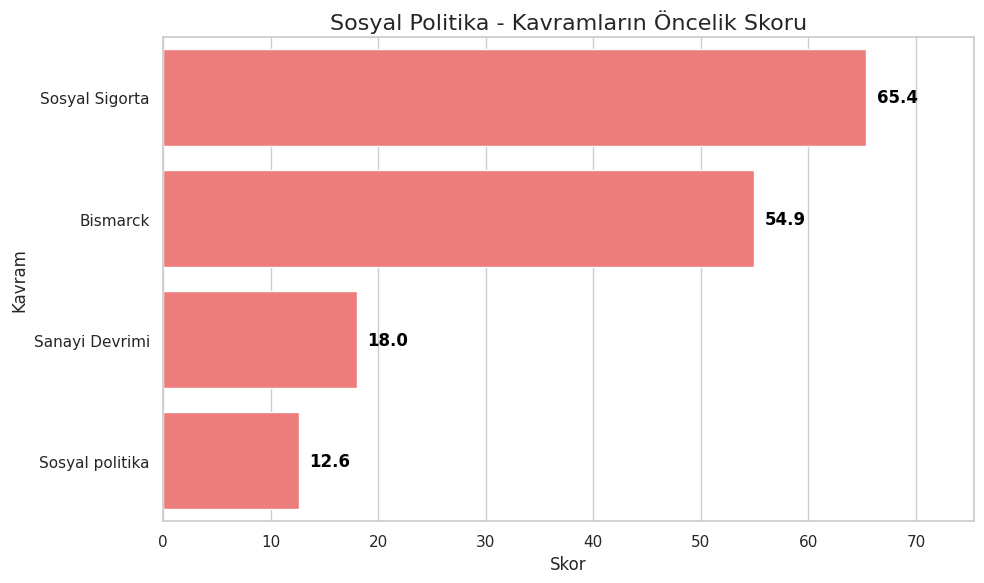

/tmp/ipython-input-1954021136.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


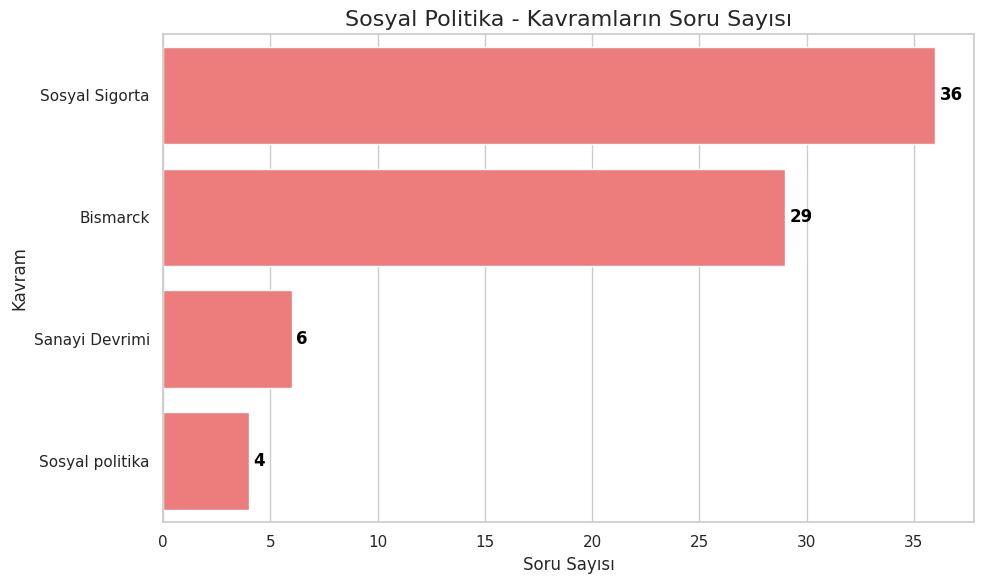

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = [
    {"Kavram": "Sosyal Sigorta", "Skor": 65.4, "Üniteler": 7, "Soru Sayısı": 36, "Tuzak": True},
    {"Kavram": "Bismarck", "Skor": 54.9, "Üniteler": 7, "Soru Sayısı": 29, "Tuzak": True},
    {"Kavram": "Sanayi Devrimi", "Skor": 18.0, "Üniteler": 5, "Soru Sayısı": 6, "Tuzak": True},
    {"Kavram": "Sosyal politika", "Skor": 12.6, "Üniteler": 3, "Soru Sayısı": 4, "Tuzak": True},
]

df = pd.DataFrame(data)

print("Sosyal Politika - Kişisel Çalışma Stratejisi Tablosu:\n")
print(df.to_string(index=False))

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
palette = ["#FF6B6B" if x else "#4ECDC4" for x in df["Tuzak"]]

sns.barplot(
    x="Skor",
    y="Kavram",
    data=df,
    palette=palette,
    orient="h"
)

plt.title("Sosyal Politika - Kavramların Öncelik Skoru", fontsize=16)
plt.xlabel("Skor")
plt.ylabel("Kavram")
plt.xlim(0, max(df["Skor"])+10)

# Skor değerlerini barların üstüne yaz
for i, v in enumerate(df["Skor"]):
    plt.text(v + 1, i, str(v), color='black', fontweight='bold', va='center')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(
    x="Soru Sayısı",
    y="Kavram",
    data=df,
    palette=palette,
    orient="h"
)
plt.title("Sosyal Politika - Kavramların Soru Sayısı", fontsize=16)
plt.xlabel("Soru Sayısı")
plt.ylabel("Kavram")

for i, v in enumerate(df["Soru Sayısı"]):
    plt.text(v + 0.2, i, str(v), color='black', fontweight='bold', va='center')

plt.tight_layout()
plt.show()


In [53]:
!pip install langchain langchain-ollama

In [54]:
# Ollama'yı arka planda kur ve başlat
!curl -fsSL https://ollama.com/install.sh | sh
import subprocess
import time

# Ollama sunucusunu arka planda başlat
process = subprocess.Popen(['ollama', 'serve'])
time.sleep(5) # Sunucunun ayağa kalkması için bekle

# Llama3 modelini indir
!ollama pull llama3

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.



In [55]:
!pip install -U langchain langchain-ollama langchain-core

* **Nasıl çalışıyor:**

  1. **Kütüphaneler ve ortam hazırlanması:** Gerekli Python kütüphaneleri (`SentenceTransformer`, `faiss`, `ChatOllama` vb.) yüklenir ve Colab ortamında kullanılabilir hale getirilir.
  2. **Metinleri yükleme:** Farklı klasörlerden (LLM besleme metinleri, özetler, soru çözümleri, tuzak kavramlar) tüm metin dosyaları okunur ve bir liste yapısında saklanır.
  3. **Embedding oluşturma:** `SentenceTransformer` kullanılarak her metin vektöre dönüştürülür. Böylece metinler **anlamsal olarak sayısal uzayda temsil edilir**.
  4. **FAISS indeksleri:** Her veri kümesi için FAISS ile birer arama indeksi oluşturulur. Bu, ileride öğrencinin sorgusu ile en benzer metinleri hızlıca bulmayı sağlar.
  5. **FAISS sorgulama fonksiyonu:** Girilen öğrenci sorusu veya kavram sorgusu, embedding’e çevrilir ve ilgili indekste **en yakın metinler** hızlıca bulunur.
  6. **LLM entegrasyonu:** `ChatOllama` ile metinlerden anlam çıkarma, stratejik analiz ve öğrenciye yol gösterme aşamaları için hazır bir LLM başlatılır.

* **Çıktı:** Bu altyapı, sonraki aşamalarda öğrencinin sorgusuna uygun metinleri çekip LLM ile analiz etmesini sağlar; yani **veri hazırlığı, anlamsal arama ve LLM entegrasyonu** işlevini üstlenir.



In [73]:
# --- 1. Kütüphaneler ---
import os
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage

# --- 2. Klasörlerden metinleri oku ---
def read_folder(folder_path):
    """Klasördeki tüm dosyaları oku ve text listesi olarak döndür."""
    texts = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        with open(file_path, "r", encoding="utf-8") as f:
            content = f.read()
            texts.append({
                "file_name": file,
                "content": content
            })
    return texts

# Klasör yolları
llm_besleme_texts = read_folder("/content/drive/MyDrive/llm_besleme")
ozet_texts = read_folder("/content/drive/MyDrive/sosyalpolitikaOzetTXT-20251228T151302Z-3-001/sosyalpolitikaOzetTXT")
soru_cozum_texts = read_folder("/content/drive/MyDrive/soru_cozum_islenmemis")
tuzak_texts = read_folder("/content/drive/MyDrive/llm_besleme")  # tuzak kavram klasörü

# --- 3. Embedding modeli ---
model = SentenceTransformer('all-MiniLM-L6-v2')

def create_embeddings(texts):
    embeddings = []
    for item in tqdm(texts):
        emb = model.encode(item['content'])
        embeddings.append({
            "file_name": item["file_name"],
            "content": item["content"],
            "embedding": emb
        })
    return embeddings

llm_besleme_emb = create_embeddings(llm_besleme_texts)
ozet_emb = create_embeddings(ozet_texts)
soru_cozum_emb = create_embeddings(soru_cozum_texts)
tuzak_emb = create_embeddings(tuzak_texts)

# --- 4. FAISS indeksleri ---
def build_faiss_index(embeddings):
    dim = embeddings[0]['embedding'].shape[0]
    index = faiss.IndexFlatL2(dim)
    vectors = np.array([e['embedding'] for e in embeddings])
    index.add(vectors)
    return index

llm_index = build_faiss_index(llm_besleme_emb)
ozet_index = build_faiss_index(ozet_emb)
soru_index = build_faiss_index(soru_cozum_emb)
tuzak_index = build_faiss_index(tuzak_emb)

# --- 5. FAISS sorgulama fonksiyonu ---
def query_index(index, embeddings, query_text, top_k=3):
    query_emb = model.encode(query_text)
    D, I = index.search(np.array([query_emb]), top_k)
    results = [embeddings[idx]['content'] for idx in I[0]]
    return results

# --- 6. Ollama LLM ---
llm = ChatOllama(model="llama3", temperature=0.2)

100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Here's the response:

**1. Öncelikli Üniteleri Sırala**

The priority units are:

* Sosyal Politika (Social Policy)
* Sigorta (Insurance)
* Engelli Çalışır (Disabled Workers)

**2. Her Ünite için Kritik Kavramları Yaz**

For each unit, the critical concepts are:

* Sosyal Politika:
	+ Sosyal Devlet (Welfare State)
	+ Sosyal Ayrımcılık (Social Exclusion)
	+ Nice Anlaşması (Nice Agreement)
* Sigorta:
	+ Zorunlu Sigorta (Compulsory Insurance)
	+ Bismarck Modelleri (Bismarck Models)
	+ Geçici İş Göremezlik Ödeneği (Temporary Disability Benefit)
* Engelli Çalışır:
	+ 4059 sayılı Kanun (Law No. 4059)
	+ Zorunlu Sigorta (Compulsory Insurance)

**3. Öğrenci Bu Konulara NASIL Çalışmalı Açıkla**

To study these concepts, students should:

* Read and analyze the relevant laws and regulations
* Research the historical context of social policy in Turkey
* Study the different models of social insurance and their implications
* Analyze case studies of disabled workers and their experiences

**4. Tuza

In [75]:
def run_study_assistant(student_input):
    # FAISS sorgusu ile gerçek veri çek
    llm_docs_list = query_index(llm_index, llm_besleme_emb, student_input)
    ozet_docs_list = query_index(ozet_index, ozet_emb, student_input)
    soru_docs_list = query_index(soru_index, soru_cozum_emb, student_input)
    tuzak_docs_list = query_index(tuzak_index, tuzak_emb, student_input)

    # Metinleri birleştir
    llm_docs_text = "\n".join(llm_docs_list)
    ozet_docs_text = "\n".join(ozet_docs_list)
    soru_docs_text = "\n".join(soru_docs_list)
    tuzak_text = "\n".join(tuzak_docs_list)

    # Chat mesajları
    system_msg = SystemMessage(content="""
Sen deneyimli bir üniversite hocası ve eğitim koçusun.
Amacın öğrenciyi STRATEJİK ve VERİYE DAYALI şekilde yönlendirmek.
- Sadece başlık vermek yetmez, konuların en kritik noktalarını ve sık sorulan soruları özetle
- Gereksiz tekrar yapma
- Önce en önemli konuları söyle
- Her ünite için: kritik kavramlar, örnek sorular ve öğrenme ipuçları ver
- Tuzak kavramları özellikle vurgula
- Öğrenciye net bir çalışma planı hazırla
- Sadece Türkçe cevap ver
""")

    user_msg = HumanMessage(content=f"""
Öğrenci: "{student_input}"

### LLM BESLEME KAYNAKLARI
{llm_docs_text}

### ÜNİTE ÖZETLERİ
{ozet_docs_text}

### SORU ÇÖZÜM KAYNAKLARI
{soru_docs_text}

### TUZAK KAVRAMLAR
{tuzak_text}

Lütfen:
1. Öncelikli üniteleri sırala
2. Her ünite için kritik kavramları, en çok sorulan soruları ve önemli noktaları açıkla
3. Öğrenci bu konulara NASIL çalışmalı adım adım anlat
4. Tuzak noktaları belirt
5. En sonunda kısa bir çalışma planı ver
6. Cevapları Türkçe yaz
""")

    # LLM çağrısı
    response = llm.invoke([system_msg, user_msg])
    return response.content

# Örnek kullanım
try:
    output = run_study_assistant("Sosyal politika dersine çalışmak istiyorum")
    print(output)
except Exception as e:
    print(f"Hata oluştu: {e}. Ollama'nın çalıştığından ve modelin indiğinden emin olun.")


**Öncelikli Üniteler:**

1. Sosyal Politika
2. Sigorta ve Sosyal Sigorta
3. Engelli Çalışır
4. Çocuk Koruma
5. Sosyal Devlet

**Kritik Kavramlar:**

1. Sosyal Politika: Sosyal politika, devletin sosyal sorunlara çözüm bulma yöntemidir.
2. Sigorta: Sigorta, çalışanların iş kazası veya hastalık gibi durumlarında gelirini korumak için alınan bir önlemektir.
3. Sosyal Sigorta: Sosyal sigorta, çalışanların engelli olmadıkları sürece çalışmaya devam etmesini sağlar.
4. Engelli Çalışır: Engelli çalışanlar, iş kazası veya hastalık gibi durumlarında sosyal sigortaya başvurarak gelirini korumak için kullanılır.
5. Çocuk Koruma: Çocuk koruma, 18 yaşını doldurmamış çocukların korunmasına yönelik sosyal politikalar olarak tanımlanır.

**En Çok Sorulan Sorular:**

1. Sosyal politika nedir?
2. Sigorta ve sosyal sigorta arasındaki fark nedir?
3. Engelli çalışanlar için hangi sosyal sigorta uygulaması kullanılır?
4. Çocuk koruma kuralları nelerdir?
5. Sosyal devlet nedir?

**Önemli Noktalar:**

1. Sosy